<a href="https://colab.research.google.com/github/yuminkim97/AI_Project2/blob/main/AI_01_%EA%B9%80%EC%9C%A0%EB%AF%BC_project2_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

vaers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAERS/2021VAERSDATA.csv', encoding = 'ISO-8859-1')
vaers_vax = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAERS/2021VAERSVAX.csv')

데이터는 백신을 접종받은 사람의 id를 공유하는 2개의 data set을 사용하며,

vaers는 접종받은 사람의 정보(나이, 사망 여부 등)

vaers_vax는 접종받은 vaccine 정보를 담고 있다.

covid19 백신을 접종받은 사람을 대상으로 부작용 정도(사망여부, 입원기간 등)를 점수화하여 그것을 target으로 진행하려 한다.

(데이터 수집 기관에 따르면 사망 등 치명적인 부작용에 백신 이외의 외부 환경 요인이 작용하였을 가능성은 현저히 낮다)

데이터 출처 : https://vaers.hhs.gov/data/datasets.html? (2021년 데이터)

데이터 설명 : https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf

In [ ]:
# COVID19 vaccine recipient 만 추출한다
covid19_recip_id = vaers_vax[vaers_vax['VAX_TYPE']=='COVID19'].VAERS_ID

vaers_vax_covid19 = vaers_vax[vaers_vax['VAERS_ID'].isin(covid19_recip_id)]
vaers_covid19 = vaers[vaers['VAERS_ID'].isin(covid19_recip_id)]

###vaers_vax data set 수정

vaccine 종류를 알 수 없는 data들은 모든 정보가 결측값인 것이 대부분 이었고, 그나마 vaccine lot 가 기록되어있는 id 919620에 대해서는 covid19 백신의 lot와 같으므로 중복되어 기입된 값이라고 생각할 수 있음

따라서 vaccine 종류가 unknown인 data 모두 제거

In [ ]:
#중복 id 추출
dup_vaers_vax = vaers_vax_covid19['VAERS_ID'].value_counts()
dup_vaers_vax_id = dup_vaers_vax[dup_vaers_vax.values>=2].index

#중복 id중 vaccine 종류가 unknown인 data 제거
vaers_vax_covid19.drop(index=vaers_vax_covid19[vaers_vax_covid19.VAX_TYPE=='UNK'].index, inplace=True)

#완벽하게 같은 row 제거
vaers_vax_covid19.drop_duplicates(inplace=True)

#같은 회사의 제품을 접종하였으면 한개의 row만 남겨두고 제거
dup_vaers_vax = vaers_vax_covid19['VAERS_ID'].value_counts()
dup_vaers_vax_id = dup_vaers_vax[dup_vaers_vax.values>=2].index
dup_vaers_vax_covid19 = vaers_vax_covid19[vaers_vax_covid19.VAERS_ID.isin(dup_vaers_vax_id)]
vaers_vax_covid19.drop(index=vaers_vax_covid19[vaers_vax_covid19.VAERS_ID.isin(dup_vaers_vax_id)].index, inplace=True)

#아래 3개의 id에 대해서는 서로다른 2개의 백신을 접종했다고 기록되어 있음. 아래 3개 데이터 이외에는 중복값으로 취급
dup_2_vaers_vax_covid19 = dup_vaers_vax_covid19.loc[dup_vaers_vax_covid19.VAERS_ID.isin([967274, 973267])]
dup_vaers_vax_covid19.drop(index=dup_vaers_vax_covid19[dup_vaers_vax_covid19.VAERS_ID.isin([967274, 973267])].index, inplace=True)

In [ ]:
#중복 id 제거
dup_vaers_vax_covid19.drop_duplicates(['VAERS_ID'], inplace=True)

#정리된 vaers_vax 데이터 셋
vaers_vax_covid19 = pd.concat([vaers_vax_covid19, dup_vaers_vax_covid19])

#vaers_vax data set 의 feature VAERS_ID를 기준으로 vaers + vaers_vax 데이터 셋 합침
vaers_covid19_merge = pd.merge(vaers_vax_covid19, vaers_covid19, on='VAERS_ID', how='left')

In [ ]:
vaers_covid19_merge.head(3)

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916710,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),01/01/2021,MO,23.0,23.0,NaN,F,NaN,"Acute appendicitis, onset morning of 1/1/2021 ...",NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,U,12/29/2020,01/01/2021,3.0,"WBCs 13k, 4% Bands, CT with acute appendicitis...",PVT,NaN,Synthroid,NaN,Hypothyroidism,NaN,NaN,2.0,01/01/2021,NaN,NaN,Y,NKDA
1,916720,COVID19,MODERNA,011L20A,1,IM,AR,COVID19 (COVID19 (MODERNA)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,916741,COVID19,PFIZER\BIONTECH,EH9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),01/01/2021,AR,68.0,68.0,NaN,F,NaN,"on dec 22 I felt some myalgias, chills, fatigu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,12/21/2020,12/22/2020,1.0,Dec 29th - saw surgeon. had xray and exam --d...,PVT,NaN,phenobarbital 60mg HS hydroxychloroquin 400mg...,had surgery R hand for advanced arthritis 11/1...,Rheumatoid arthritis - mostly affecting R wris...,NaN,NaN,2.0,01/01/2021,NaN,NaN,NaN,bee stings


In [ ]:
#심각한 부작용을 겪은 사람 수
vaers_covid19_merge['L_THREAT'].value_counts()

Y    304
Name: L_THREAT, dtype: int64

In [ ]:
#그 중 회복된 사람 수
vaers_covid19_merge[(vaers_covid19_merge['L_THREAT']=='Y')]['RECOVD'].value_counts()

N    125
Y    119
U     54
Name: RECOVD, dtype: int64

In [ ]:
#심각한 부작용을 겪었고 회복한 사람 중 사망했다고 기록된 데이터가 있는지 확인
vaers_covid19_merge[(vaers_covid19_merge['L_THREAT']=='Y')&(vaers_covid19_merge['RECOVD']=='Y')]['DIED'].value_counts()

Series([], Name: DIED, dtype: int64)

In [ ]:
#심각한 부작용을 겪는 사람 중 사망한 사람 수
vaers_covid19_merge[vaers_covid19_merge['L_THREAT']=='Y']['DIED'].value_counts()

Y    4
Name: DIED, dtype: int64

In [ ]:
#사망한 사람 수
vaers_covid19_merge['DIED'].value_counts()

Y    430
Name: DIED, dtype: int64

In [ ]:
#심각한 부작용을 겪었지만 사망하지 않았다고 기록된 사람 회복여부
vaers_covid19_merge[(vaers_covid19_merge['L_THREAT']=='Y')&pd.isnull(vaers_covid19_merge['DIED'])]['RECOVD'].value_counts()

N    121
Y    119
U     54
Name: RECOVD, dtype: int64

symptom feature는 값들에 규칙성이 없이 기록되었기에 다루기 어렵다고 판단하였으며, 따라서 부작용이 발생한 사람 중 L_treat나 died에 y로 표기된 심각한 부작용이 발생한 접종대상자에 대해 예측을 진행한다.

In [ ]:
#치명적인 증상의 발생 여부를 'fatal' feature에 저장
vaers_covid19_merge['fatal'] = 0

for row in vaers_covid19_merge.index :
  if ((vaers_covid19_merge.loc[row, 'DIED']=='Y') | (vaers_covid19_merge.loc[row, 'L_THREAT']=='Y')) :
      vaers_covid19_merge.loc[row, 'fatal'] = 1

###feature 전처리

In [ ]:
#값이 unknown일 때 NaN으로 기입되거나 unknown이라고 기입되는데, 이를 통합
vaers_covid19_merge['VAX_MANU'].fillna('UNKNOWN MANUFACTURER', inplace=True)
vaers_covid19_merge['V_ADMINBY'].fillna('UNK', inplace=True)
# vaers_covid19_merge['VAX_ROUTE'].fillna('UN', inplace=True)
vaers_covid19_merge['SEX'].fillna('U', inplace=True)
vaers_covid19_merge['fatal'].fillna(0, inplace=True)

#숫자형 데이터인 VAX_DOSE_SERIES의 경우 7+라는 값 때문에 ordinal encoding 이후 새로운 값에 mapping 되므로 7+를 7로 변경
vaers_covid19_merge['VAX_DOSE_SERIES'].replace('UNK', np.nan, inplace=True)
vaers_covid19_merge['VAX_DOSE_SERIES'].replace('7+', 7, inplace=True)
# vaers_covid19_merge['VAX_DOSE_SERIES'].fillna(0, inplace=True)
vaers_covid19_merge['VAX_DOSE_SERIES'] = vaers_covid19_merge['VAX_DOSE_SERIES'].astype('float')

#BIRTH_DEFECT의 경우 편의상 N=0, Y=1로 변경
vaers_covid19_merge['BIRTH_DEFECT'].replace('Y', 1, inplace=True)
vaers_covid19_merge['BIRTH_DEFECT'].fillna(0, inplace=True)

In [ ]:
vaers_covid19_merge['VAX_ROUTE'].replace(['UN', 'OT'], np.nan, inplace=True)
vaers_covid19_merge['VAX_ROUTE'].value_counts()

IM     1679
SYR     204
SC        9
Name: VAX_ROUTE, dtype: int64

IM(Intramuscular), SYR(Needle and syringe), SC(Subcutaneous) - 코로나 19백신 접종 방법은 모두 근육주사이고, 이 세가지 방법 모두 근육주사를 의미하는 것으로 보이므로 이 feature는 예측에 사용하지 않음

In [ ]:
vaers_covid19_merge['VAX_DOSE_SERIES'].value_counts()

1.0    2487
2.0     425
3.0       2
5.0       2
7.0       1
4.0       1
Name: VAX_DOSE_SERIES, dtype: int64

코로나 백신은 대부분 총 2회 접종하는 백신으로, VAX_DOSE_SERIES(백신 투여량)이 2 이상인 data의 경우 이상치로 취급하여 제거하였다.

In [ ]:
vaers_covid19_merge = vaers_covid19_merge[~(vaers_covid19_merge['VAX_DOSE_SERIES']>=3)]

###만성질환 및 병력 feature 생성

In [ ]:
vaers_covid19_merge['HISTORY'] = vaers_covid19_merge['HISTORY'].str.lower()

In [ ]:
vaers_covid19_merge['HISTORY'].replace(['comments: list of non-encoded patient relevant history: patient other relevant history 1: none', 
                                        'none', 'unknown', 'no'], np.nan, inplace=True)

In [ ]:
vaers_covid19_merge['HISTORY'].value_counts()

asthma                                                                                               23
hypertension                                                                                         15
hypothyroidism                                                                                       11
diabetes                                                                                             10
medical history/concurrent conditions: hypertension                                                   7
                                                                                                     ..
insomnia                                                                                              1
asthma    developmental delay (pediatric)    eczema    hld (hyperlipidemia)    htn (hypertension)     1
medical history/concurrent conditions: covid-19 (i had covid back on the 4th of december.)            1
essential htn, dm, spinal stenosis, hyperlipidemia,osteoarthriti

In [ ]:
vaers_covid19_merge['HISTORY'].fillna('', inplace=True)

In [ ]:
#호흡기질환 환자

vaers_covid19_merge['pulmonary_disoreder'] = 0
vaers_covid19_merge['pulmonary_disoreder'][(vaers_covid19_merge['HISTORY'].str.contains('pulmonary'))|(vaers_covid19_merge['HISTORY'].str.contains('asthma'))
                                 |(vaers_covid19_merge['HISTORY'].str.contains('lung'))|(vaers_covid19_merge['HISTORY'].str.contains('copd'))
                                 |(vaers_covid19_merge['HISTORY'].str.contains('bronchitis'))|(vaers_covid19_merge['HISTORY'].str.contains('pneumonia'))] = 1
vaers_covid19_merge['pulmonary_disoreder'].value_counts()

0    3317
1     269
Name: pulmonary_disoreder, dtype: int64

In [ ]:
vaers_covid19_merge['hypertension'] = 0
vaers_covid19_merge['hypertension'][(vaers_covid19_merge['HISTORY'].str.contains('hypertension'))|(vaers_covid19_merge['HISTORY'].str.contains('high blood'))
|(vaers_covid19_merge['HISTORY'].str.contains('blood pressure'))]=1
vaers_covid19_merge['hypertension'].value_counts()

0    3280
1     306
Name: hypertension, dtype: int64

In [ ]:
vaers_covid19_merge['high_cholesterol'] = 0
vaers_covid19_merge['high_cholesterol'][(vaers_covid19_merge['HISTORY'].str.contains('cholest'))]=1
vaers_covid19_merge['high_cholesterol'].value_counts()

0    3543
1      43
Name: high_cholesterol, dtype: int64

In [ ]:
vaers_covid19_merge['arthritis'] = 0
vaers_covid19_merge['arthritis'][(vaers_covid19_merge['HISTORY'].str.contains('arthritis'))|
                                 (vaers_covid19_merge['HISTORY'].str.contains('joint'))]=1
vaers_covid19_merge['arthritis'].value_counts()

0    3498
1      88
Name: arthritis, dtype: int64

In [ ]:
vaers_covid19_merge['cardiac_disorder'] = 0
vaers_covid19_merge['cardiac_disorder'][(vaers_covid19_merge['HISTORY'].str.contains('cardiac'))|(vaers_covid19_merge['HISTORY'].str.contains('heart'))
|(vaers_covid19_merge['HISTORY'].str.contains('cardio'))|(vaers_covid19_merge['HISTORY'].str.contains('cvd'))] = 1
vaers_covid19_merge['cardiac_disorder'].value_counts()

0    3445
1     141
Name: cardiac_disorder, dtype: int64

In [ ]:
vaers_covid19_merge['diabetes'] = 0
vaers_covid19_merge['diabetes'][(vaers_covid19_merge['HISTORY'].str.contains('diabetes'))
                                |(vaers_covid19_merge['HISTORY'].str.contains('dm'))] = 1
vaers_covid19_merge['diabetes'][(vaers_covid19_merge['HISTORY'].str.contains('admission'))] = 0
vaers_covid19_merge['diabetes'].value_counts()

0    3361
1     225
Name: diabetes, dtype: int64

In [ ]:
vaers_covid19_merge['kidney_disorder'] = 0
vaers_covid19_merge['kidney_disorder'][(vaers_covid19_merge['HISTORY'].str.contains('kidney'))|(vaers_covid19_merge['HISTORY'].str.contains('ckd'))] = 1
vaers_covid19_merge['kidney_disorder'].value_counts()

0    3503
1      83
Name: kidney_disorder, dtype: int64

In [ ]:
vaers_covid19_merge['depression'] = 0
vaers_covid19_merge['depression'][(vaers_covid19_merge['HISTORY'].str.contains('depression'))|(vaers_covid19_merge['HISTORY'].str.contains('depressive'))] = 1
vaers_covid19_merge['depression'].value_counts()

0    3471
1     115
Name: depression, dtype: int64

In [ ]:
vaers_covid19_merge['alzheimer'] = 0
vaers_covid19_merge['alzheimer'][(vaers_covid19_merge['HISTORY'].str.contains('alz'))] = 1
vaers_covid19_merge['alzheimer'].value_counts()

0    3561
1      25
Name: alzheimer, dtype: int64

In [ ]:
# vaers_covid19_merge['num_of_chronic'] = 0
# vaers_covid19_merge['num_of_chronic'] = (vaers_covid19_merge['pulmonary_disoreder']+vaers_covid19_merge['hypertension']
#                                         +vaers_covid19_merge['high_cholesterol']+vaers_covid19_merge['arthritis']
#                                         +vaers_covid19_merge['cardiac_disorder']+vaers_covid19_merge['diabetes']
#                                         +vaers_covid19_merge['kidney_disorder']+vaers_covid19_merge['depression']
#                                         +vaers_covid19_merge['alzheimer'])
# vaers_covid19_merge['num_of_chronic'].value_counts()

###알레르기 data 확인

백신과 무관한 알레르기가 있는 경우
CDC는 음식, 반려동물, 유독물, 환경, 라텍스 알레르기와 같은 백신 또는 주사용 약물과 무관한 심각한 알레르기 반응 병력이 있는 사람에게는 백신 접종을 권장합니다. 경구 약물에 대한 알레르기 병력이 있거나 심각한 알레르기 반응 가족력이 있는 사람도 백신 접종을 받을 수 있습니다.

폴리에틸렌 글리콜(PEG) 또는 폴리소르베이트에 알레르기 반응이 있는 경우
이러한 권장사항은 PEG 및 폴리소르베이트에 대한 알레르기 반응에도 적용됩니다. 폴리소르베이트는 mRNA COVID-19 백신에 들어가는 성분이 아니지만 백신에 있는 PEG와 밀접한 관련성이 있습니다. PEG 또는 폴리소르베이트에 알레르기가 있는 사람은 mRNA COVID-19 백신을 접종해서는 안됩니다.

https://korean.cdc.gov/coronavirus/2019-ncov/vaccines/safety/allergic-reaction.html

In [ ]:
vaers_covid19_merge['ALLERGIES'] = vaers_covid19_merge['ALLERGIES'].str.lower()

In [ ]:
vaers_covid19_merge['ALLERGIES'].value_counts()

none                                                                                                                                                                                241
nka                                                                                                                                                                                  74
nkda                                                                                                                                                                                 71
no known allergies                                                                                                                                                                   49
unknown                                                                                                                                                                              38
                                                                                

In [ ]:
vaers_covid19_merge['ALLERGIES'].replace(['none', 'nka', 'nkda', 'no', 'none known',
                                          'no known allergies', 'unknown', 'none reported'], np.nan, inplace=True)

In [ ]:
vaers_covid19_merge['ALLERGIES'].fillna('', inplace=True)

In [ ]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polyethylen'))].values

array(["i'm allergic to dg6 or most likely iodine,  and to chloroquine which has polyethylene_glycol, a component of moderna covid vaccione. i did not know about this component. i was asked if i had adverse reactions to components in the moderna vaccione but i was asked if i had adverse reactions to choloroquine."],
      dtype=object)

In [ ]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polyethylen'))].index

Int64Index([1752], dtype='int64')

In [ ]:
vaers_covid19_merge['ALLERGIES'][(vaers_covid19_merge['ALLERGIES'].str.contains('polysorbate'))]

Series([], Name: ALLERGIES, dtype: object)

폴리에틸렌 글리콜 알레르기 반응이 있는 사람이 한명 있었고, 심각한 증상을 겪었으며 현재 회복되었다.

###데이터 분포 확인

> 나이

In [ ]:
min(vaers_covid19_merge['AGE_YRS']), max(vaers_covid19_merge['AGE_YRS'])

(1.08, 105.0)

In [ ]:
  for r in vaers_covid19_merge.index :
    for y in list(range(10, 120, 10)):
      if vaers_covid19_merge.loc[r, 'AGE_YRS'] <= y : 
        vaers_covid19_merge.loc[r, 'AGE_YRS_range'] = y-10
        break

fatal = pd.DataFrame(vaers_covid19_merge['fatal'].groupby(vaers_covid19_merge['AGE_YRS_range']).mean()).reset_index()

In [ ]:
age = pd.DataFrame(vaers_covid19_merge['AGE_YRS_range'].value_counts()).reset_index()

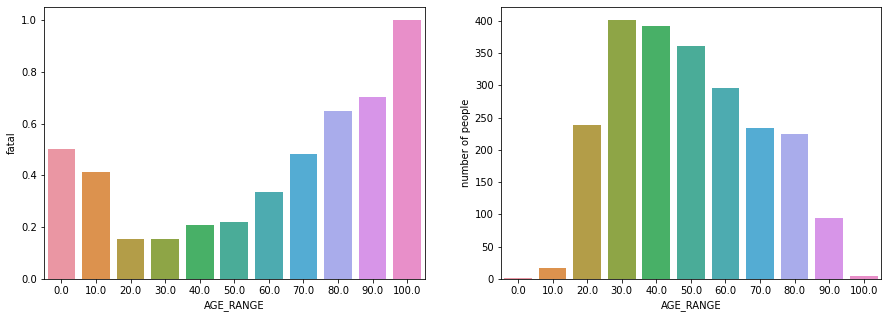

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='AGE_YRS_range', y='fatal', data=fatal, ax=ax1)
ax1.set_xlabel('AGE_RANGE')
ax1.set_ylabel('fatal')
sns.barplot(x='index', y='AGE_YRS_range', data=age, ax=ax2)
ax2.set_xlabel('AGE_RANGE')
ax2.set_ylabel('number of people')
plt.show()

다른 나이대는 적어도 50명 이상의 데이터가 있지만, 20대 미만, 90대 이상의 데이터는 부족하다.

###사용할 feature 선택 
예측에 사용할 feature 선택 : VAERS_ID, VAX_TYPE(백신 종류), VAX_MANU(백신 제조사), VAX_DOSE_SERIES(복용량), STATE(주), AGE_YRS(나이), SEX(성별), V_ADMINBY(백신 관리 기관), BIRTH_DEFECT(백신에 영향 받을 수 있는 선천장애 여부)

In [ ]:
#선택한 feature 추출
vaers_covid19_class = vaers_covid19_merge.loc[:,['VAX_MANU', 'VAX_DOSE_SERIES', 'STATE', 'AGE_YRS', 'SEX', 'V_ADMINBY', 'BIRTH_DEFECT',
                                                'pulmonary_disoreder', 'hypertension', 'high_cholesterol', 'arthritis', 'cardiac_disorder', 'diabetes',
                                                'kidney_disorder', 'depression', 'alzheimer', 'fatal']]

In [ ]:
vaers_covid19_class.shape

(3586, 17)

In [ ]:
#train set, valid set 나눔
from sklearn.model_selection import train_test_split

train_c, test_c = train_test_split(vaers_covid19_class, test_size=0.20, stratify=vaers_covid19_class['fatal'], random_state=11)
train_c, valid_c = train_test_split(train_c, test_size=0.20, stratify=train_c['fatal'], random_state=11)

y_train_c = train_c['fatal']
X_train_c = train_c.drop(columns=['fatal'])
y_valid_c = valid_c['fatal']
X_valid_c = valid_c.drop(columns=['fatal'])
y_test_c = test_c['fatal']
X_test_c = test_c.drop(columns=['fatal'])

##데이터 전처리

Ordinal Encoder (높은 cardinality의 feature들을 가장 잘 처리할 수 있고, 원래 순서가 있는 feature는 없기 때문에)

In [ ]:
X_train_c.isna().sum() #STATE : ordinal encoder로 인해 결측값이 채워지고, state를 알 수 없는 group또한 하나의 그룹으로 취급

VAX_MANU                 0
VAX_DOSE_SERIES        439
STATE                  837
AGE_YRS                866
SEX                      0
V_ADMINBY                0
BIRTH_DEFECT             0
pulmonary_disoreder      0
hypertension             0
high_cholesterol         0
arthritis                0
cardiac_disorder         0
diabetes                 0
kidney_disorder          0
depression               0
alzheimer                0
dtype: int64

In [ ]:
!pip3 install category_encoders

     |████████████████████████████████| 81kB 4.1MB/s 


In [ ]:
from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder()

X_train_enc_c = encoder.fit_transform(X_train_c)
X_valid_enc_c = encoder.fit_transform(X_valid_c)
X_test_enc_c = encoder.transform(X_test_c)

In [ ]:
X_train_enc_c.isna().sum()

VAX_MANU                 0
VAX_DOSE_SERIES        439
STATE                    0
AGE_YRS                866
SEX                      0
V_ADMINBY                0
BIRTH_DEFECT             0
pulmonary_disoreder      0
hypertension             0
high_cholesterol         0
arthritis                0
cardiac_disorder         0
diabetes                 0
kidney_disorder          0
depression               0
alzheimer                0
dtype: int64

나이 : KNN imputer 사용 - 비슷한 정보(만성질환 종류 등)를 갖고있는 사람은 비슷한 나이대로 생각할 수 있음

In [ ]:
from sklearn.impute import KNNImputer

knn_imput = KNNImputer()
X_train_enc_c['AGE_YRS'] = knn_imput.fit_transform(X_train_enc_c[['AGE_YRS']])
X_valid_enc_c['AGE_YRS'] = knn_imput.transform(X_valid_enc_c[['AGE_YRS']])
X_test_enc_c['AGE_YRS'] = knn_imput.transform(X_test_enc_c[['AGE_YRS']])

In [ ]:
X_train_c.head()

,VAX_MANU,VAX_DOSE_SERIES,STATE,AGE_YRS,SEX,V_ADMINBY,BIRTH_DEFECT,pulmonary_disoreder,hypertension,high_cholesterol,arthritis,cardiac_disorder,diabetes,kidney_disorder,depression,alzheimer
1090,PFIZER\BIONTECH,NaN,NaN,NaN,F,UNK,0.0,0,0,0,0,0,0,0,0,0
1817,PFIZER\BIONTECH,1.0,NaN,NaN,U,UNK,0.0,0,0,0,0,0,0,0,0,0
87,PFIZER\BIONTECH,1.0,VA,50.0,F,PVT,0.0,0,0,0,0,0,0,0,0,0
2306,PFIZER\BIONTECH,1.0,CT,27.0,F,PVT,0.0,1,0,0,0,0,0,0,0,0
1789,PFIZER\BIONTECH,1.0,CA,NaN,F,PVT,0.0,1,0,0,0,0,0,0,0,0


VAX_DOSE_SERIES : simple imputer 사용 - 총 2회 접종하는 백신이며, 결측값은 평균으로 채워준다.

In [ ]:
from sklearn.impute import SimpleImputer

simp_imput = SimpleImputer()
X_train_enc_c['VAX_DOSE_SERIES'] = simp_imput.fit_transform(X_train_enc_c[['VAX_DOSE_SERIES']])
X_valid_enc_c['VAX_DOSE_SERIES'] = simp_imput.transform(X_valid_enc_c[['VAX_DOSE_SERIES']])
X_test_enc_c['VAX_DOSE_SERIES'] = simp_imput.transform(X_test_enc_c[['VAX_DOSE_SERIES']])

#Classification Problem

가장 주의깊게 확인할 평가기준 : 심각한 부작용이 발생할 수 있는 최소한의 가능성을 가진 환자라도 모니터링 하기 위해, target 1에 대한 recall값을 확인해야 할 것이다. 하지만 모니터링을 최소 인원으로 진행하기 위해서는 false positive도 너무 증가해서는 안 될 것이다. 따라서 f1 score와 recall값을 함께 확인하여 적절한 모델을 선택해야 할 것이다.

0. target 비율 확인

In [ ]:
vaers_covid19_merge['fatal'].value_counts() #imbalanced target

0    2858
1     728
Name: fatal, dtype: int64

1. 기준모델

In [ ]:
#분류문제이므로 더 많은 target 값인 0을 기준모델의 예측값으로 사용
y_pred_base_train_c = [0]*len(y_train_c)
y_pred_base_valid_c = [0]*len(y_valid_c)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_base_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_base_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_base_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_base_valid_c))

훈련 정확도 : 0.7968613775065388
검증 정확도 : 0.7979094076655052
훈련 f1 score : 0.0
검증 f1 score : 0.0


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid_c, y_pred_base_valid_c))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       458
           1       0.00      0.00      0.00       116

    accuracy                           0.80       574
   macro avg       0.40      0.50      0.44       574
weighted avg       0.64      0.80      0.71       574



정확도는 높은 편이나 f1 score가 매우 낮음 --> 모델의 성능이 낮음

2. linear model

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train_enc_c, y_train_c)

y_pred_log_train_c = log_model.predict(X_train_enc_c)
y_pred_log_valid_c = log_model.predict(X_valid_enc_c)

In [ ]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_log_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_log_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_log_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_log_valid_c))

훈련 정확도 : 0.8291194420226679
검증 정확도 : 0.8449477351916377
훈련 f1 score : 0.46448087431693985
검증 f1 score : 0.5240641711229946


In [ ]:
print(classification_report(y_pred_log_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       503
           1       0.42      0.69      0.52        71

    accuracy                           0.84       574
   macro avg       0.69      0.78      0.72       574
weighted avg       0.89      0.84      0.86       574



3. Decision tree model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model_c = DecisionTreeClassifier(max_depth=7)
tree_model_c.fit(X_train_enc_c, y_train_c)

y_pred_tree_train_c = tree_model_c.predict(X_train_enc_c)
y_pred_tree_valid_c = tree_model_c.predict(X_valid_enc_c)

In [ ]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_tree_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_tree_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_tree_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_tree_valid_c))

훈련 정확도 : 0.8718395815170009
검증 정확도 : 0.8310104529616724
훈련 f1 score : 0.6080000000000001
검증 f1 score : 0.4756756756756757


In [ ]:
print(classification_report(y_pred_tree_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       505
           1       0.38      0.64      0.48        69

    accuracy                           0.83       574
   macro avg       0.66      0.75      0.69       574
weighted avg       0.88      0.83      0.85       574



4. Random forest (Ensemble)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model_c = RandomForestClassifier(max_depth=7)
rf_model_c.fit(X_train_enc_c, y_train_c)

y_pred_rf_train_c = rf_model_c.predict(X_train_enc_c)
y_pred_rf_valid_c = rf_model_c.predict(X_valid_enc_c)

In [ ]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_rf_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_rf_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_rf_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_rf_valid_c))

훈련 정확도 : 0.8775065387968614
검증 정확도 : 0.8519163763066202
훈련 f1 score : 0.6187245590230664
검증 f1 score : 0.53551912568306


In [ ]:
print(classification_report(y_pred_rf_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       507
           1       0.42      0.73      0.54        67

    accuracy                           0.85       574
   macro avg       0.69      0.80      0.72       574
weighted avg       0.90      0.85      0.87       574



5. Ada boost (Ensemble)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_model_c = AdaBoostClassifier()
ada_model_c.fit(X_train_enc_c, y_train_c)

y_pred_ada_train_c = ada_model_c.predict(X_train_enc_c)
y_pred_ada_valid_c = ada_model_c.predict(X_valid_enc_c)

In [ ]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_ada_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_ada_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_ada_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_ada_valid_c))

훈련 정확도 : 0.8461203138622494
검증 정확도 : 0.8484320557491289
훈련 f1 score : 0.5421530479896239
검증 f1 score : 0.5347593582887701


In [ ]:
print(classification_report(y_pred_ada_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       503
           1       0.43      0.70      0.53        71

    accuracy                           0.85       574
   macro avg       0.69      0.79      0.72       574
weighted avg       0.89      0.85      0.86       574



6. XG boost

In [ ]:
from xgboost import XGBClassifier

xg_model_c = XGBClassifier()
xg_model_c.fit(X_train_enc_c, y_train_c)

y_pred_xg_train_c = xg_model_c.predict(X_train_enc_c)
y_pred_xg_valid_c = xg_model_c.predict(X_valid_enc_c)

In [ ]:
print('훈련 정확도 :', accuracy_score(y_train_c, y_pred_xg_train_c))
print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_xg_valid_c))

print('훈련 f1 score :', f1_score(y_train_c, y_pred_xg_train_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_xg_valid_c))

훈련 정확도 : 0.8548387096774194
검증 정확도 : 0.8501742160278746
훈련 f1 score : 0.553020134228188
검증 f1 score : 0.532608695652174


In [ ]:
print(classification_report(y_pred_xg_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       506
           1       0.42      0.72      0.53        68

    accuracy                           0.85       574
   macro avg       0.69      0.79      0.72       574
weighted avg       0.90      0.85      0.87       574



기준모델과 linear model과 비교하여 정확도와 recall, f1 score 모두 증가하였다.

여기서는 Randomforest 모델의 target 1에 대한 recall이 가장 높았으므로 random forest 모델을 사용

7. 과적합문제 해결 

(여기서는 randomized search cv를 사용하여 hyperparameter를 조정하여 해결)

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

vc_c = y_train_c.value_counts(normalize=True).tolist()
ratio_c = {0:vc_c[1], 1:vc_c[0]} #target의 비율이 맞지 않으므로 weight 가해줌

pipe_c = make_pipeline(
    RandomForestClassifier()
)

dists_c = {
    'randomforestclassifier__n_estimators' : range(50, 200)
    , 'randomforestclassifier__max_depth' : range(5, 20)
    , 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2']
    # , 'randomforestclassifier__min_samples_leaf' : range(5, 50)
    , 'randomforestclassifier__min_samples_split' : range(5, 50)
    , 'randomforestclassifier__criterion' : ['gini', 'entropy']
}

clf_c = RandomizedSearchCV(
    pipe_c, param_distributions=dists_c,
    n_iter=30, #hyper parameter 조합 개수
    cv=5, #cross validation 개수
    scoring='recall',
    verbose=1, #verbose : 진행상황 실시간으로 알려주는 정도 (숫자 커질수록 자세하게)
    n_jobs=1
)

clf_c.fit(X_train_enc_c, y_train_c)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   43.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                           

In [ ]:
pipe_best_c = clf_c.best_estimator_

pipe_best_c.fit(X_train_enc_c, y_train_c)
y_pred_cv_valid_c = pipe_best_c.predict(X_valid_enc_c)

print('검증 정확도 :', accuracy_score(y_valid_c, y_pred_cv_valid_c))
print('검증 f1 score :', f1_score(y_valid_c, y_pred_cv_valid_c))

검증 정확도 : 0.8449477351916377
검증 f1 score : 0.548223350253807


In [ ]:
print(classification_report(y_pred_cv_valid_c, y_valid_c))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       493
           1       0.47      0.67      0.55        81

    accuracy                           0.84       574
   macro avg       0.70      0.77      0.73       574
weighted avg       0.87      0.84      0.86       574



In [ ]:
pipe_best_c.fit(X_test_enc_c, y_test_c)
y_pred_cv_test_c = pipe_best_c.predict(X_test_enc_c)

print('테스트 정확도 :', accuracy_score(y_test_c, y_pred_cv_test_c))
print('테스트 f1 score :', f1_score(y_test_c, y_pred_cv_test_c))

테스트 정확도 : 0.9261838440111421
테스트 f1 score : 0.7969348659003832


In [ ]:
print(f'<테스트셋 classification metrics>\n{classification_report(y_pred_cv_test_c, y_test_c)}')

<테스트셋 classification metrics>
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       603
           1       0.71      0.90      0.80       115

    accuracy                           0.93       718
   macro avg       0.85      0.92      0.88       718
weighted avg       0.94      0.93      0.93       718



test set에 대한 recall 값이 validaiont set의 결과보다 높게 나왔다. 아마 우연인 듯 하지만, recall 값이 높아서 조금이라도 심각한 부작용 가능성을 보일 수 있는 접종대상자를 모니터링하기 위해서는 높은 recall값을 보이는 것이 적절하다고 판단된다.

#Permutation importance

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 77kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=89c943b5a3bf4ed54eb3e43d3a9b14a72343a0e7b2492773d331fb0592febeef
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
!pip3 install eli5

     |████████████████████████████████| 112kB 10.5MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_c = PermutationImportance(
    pipe_best_c.named_steps['randomforestclassifier'],
    scoring='f1',
    n_iter=5,
    random_state=11
)

permuter_c.fit(X_train_enc_c, y_train_c);

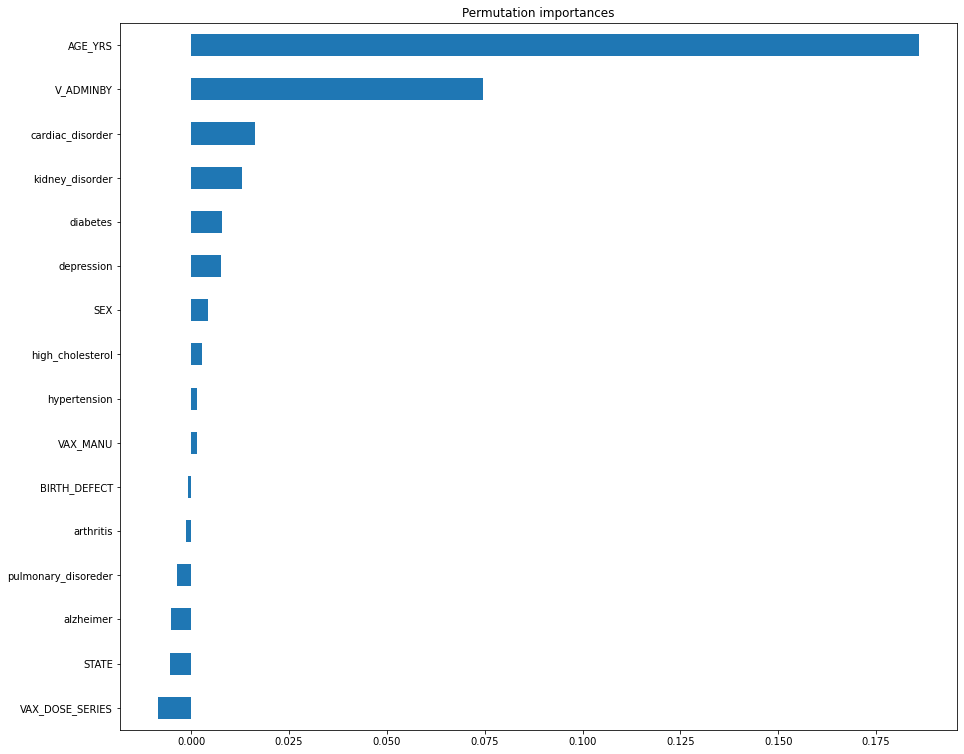

In [ ]:
plt.figure(figsize=(15,13))

feature_names_c = X_test_enc_c.columns.tolist()
permut_importances_c = pd.Series(permuter_c.feature_importances_, feature_names_c).sort_values()

permut_importances_c.sort_values().plot.barh();
plt.title("Permutation importances");

'나이'가 '심각한 부작용을 일으킬 가능성에' 가장 큰 영향을 주었으며, 백신관리기관, 심혈관계 질환 유무, 신장질환유무 등이 '심각한 부작용을 일으킬 가능성에' positive한 영향을 주는 것을 확인할 수 있었다.

In [ ]:
# encoder.category_mapping

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


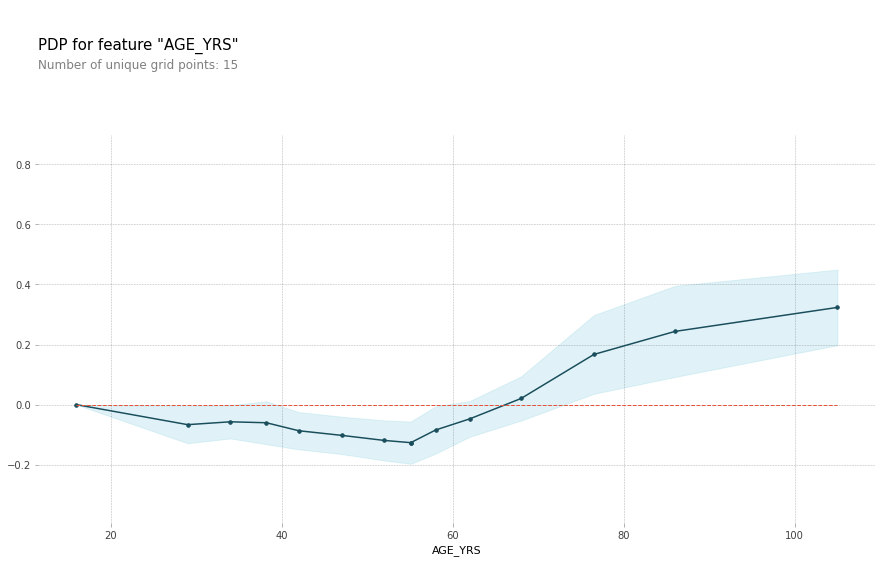

In [ ]:
#나이가 target에 끼치는 영향 시각화
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'AGE_YRS'

isolated = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_enc_c, 
    model_features=X_test_enc_c.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);

domain knowledge와 일치하는 결과로, 65세 이상인 접종대상자에게 부작용이 일어날 가능성이 크게 증가하였다.

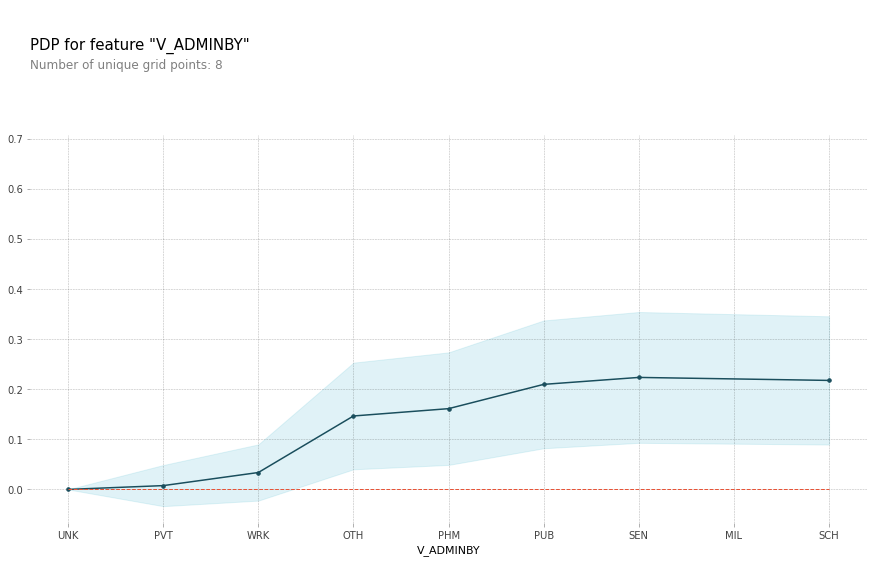

In [ ]:
#백신보관기관이 target에 끼치는 영향 시각화

feature = 'V_ADMINBY'

isolated = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_enc_c, 
    model_features=X_test_enc_c.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['UNK', 'PVT', 'WRK', 'OTH', 'PHM', 'PUB', 'SEN', 'MIL', 'SCH']);

SEN(=Nursing home or senior
living facility) 에서 보관한 백신에서 높은 확률로 부작용이 발생했다. 아마 환자나 노인을 수용하는 시설이라 높은 부작용 률을 보인 것으로 생각된다.

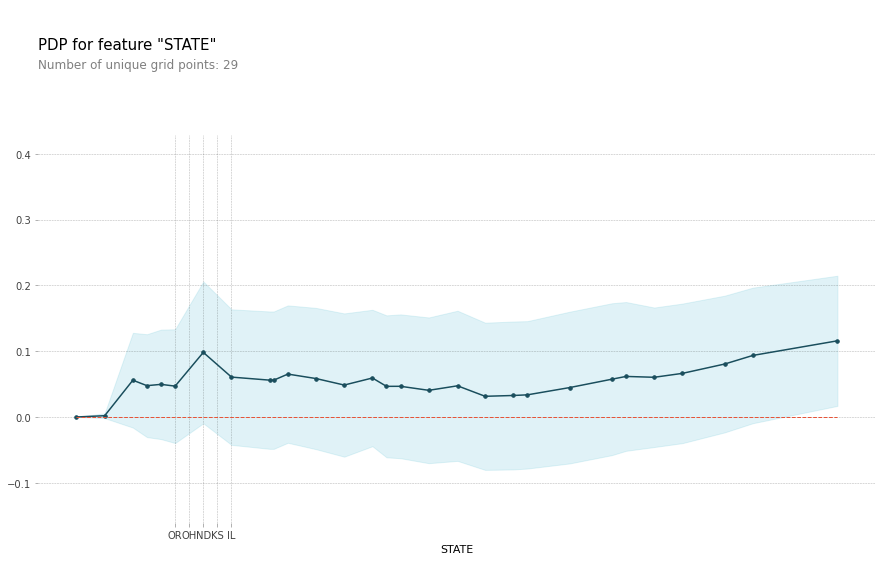

In [ ]:
feature = 'STATE'

isolated = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_enc_c, 
    model_features=X_test_enc_c.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=50
)

pdp_plot(isolated, feature_name=feature);
plt.xticks([6, 7, 8, 9, 10], ['OR', 'OH', 'ND', 'KS', 'IL']);

ND(노스다코타주, North Dakota)에서 가장 높은 심각한 부작용 발생률을 보였다. 우연일 수도 있지만, 백신 관리에 있어 문제가 있었을 수 있고, 혹은 같은 생산환경에서 제작된 (같은 로트번호를 가진) 백신에 문제가 있었을 수 있다.

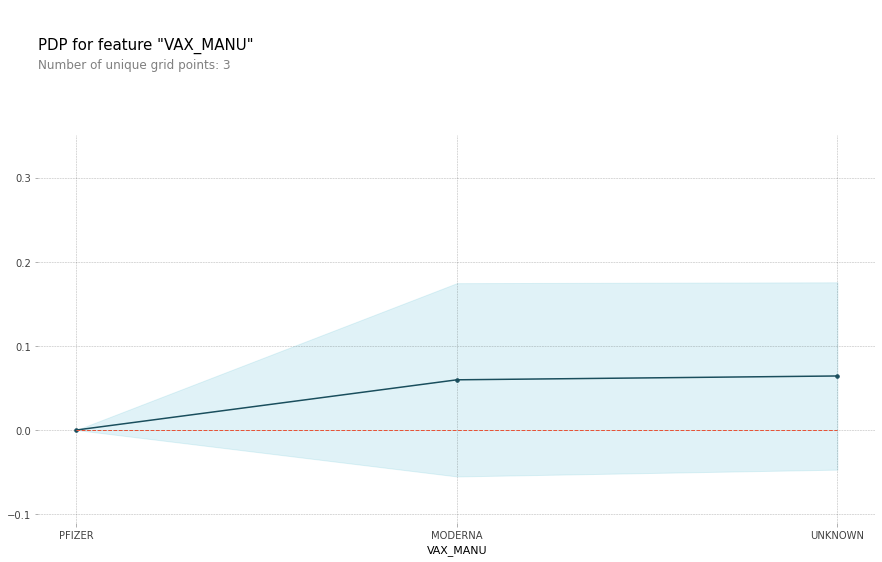

In [ ]:
feature = 'VAX_MANU'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_enc_c, 
    model_features=X_test_enc_c.columns, 
    feature=feature
)

pdp_plot(isolated_c, feature_name=feature);
plt.xticks([1, 2, 3], ['PFIZER', 'MODERNA', 'UNKNOWN']);

화이자보다 모더나에서 더 높은 심각한 부작용 률을 보였다.

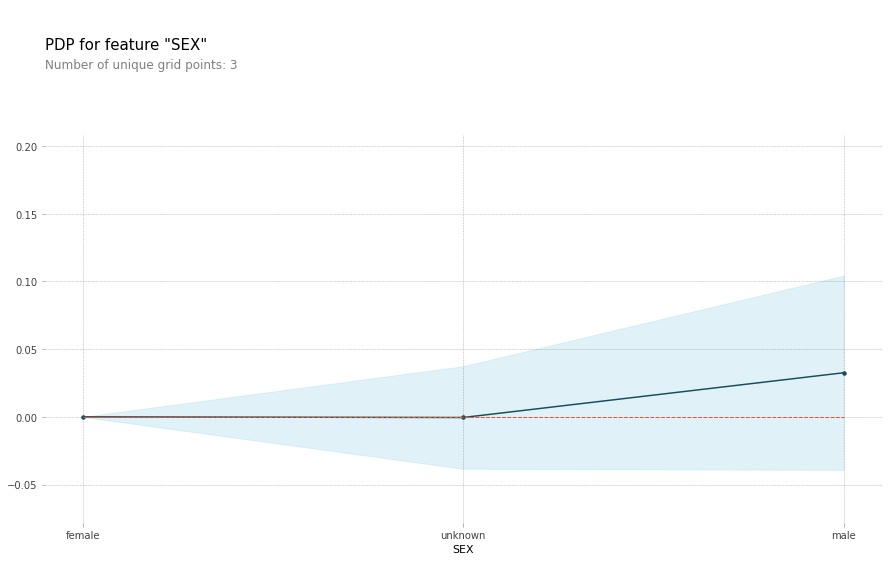

In [ ]:
#성별이 target에 끼치는 영향 시각화
feature = 'SEX'

isolated_c = pdp_isolate(
    model=pipe_best_c, 
    dataset=X_test_enc_c, 
    model_features=X_test_enc_c.columns, 
    feature=feature
)

pdp_plot(isolated_c, feature_name=feature);
plt.xticks([1, 2, 3], ['female', 'unknown', 'male']);

여성보다 남성에게서 부작용 발생 가능성이 약간 더 높았다. 이것은 domain knowledge와는 상반된 결과로, 다른 요소와 같이 작용했을 때 이런 영향을 끼쳤다고 생각할 수 있다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


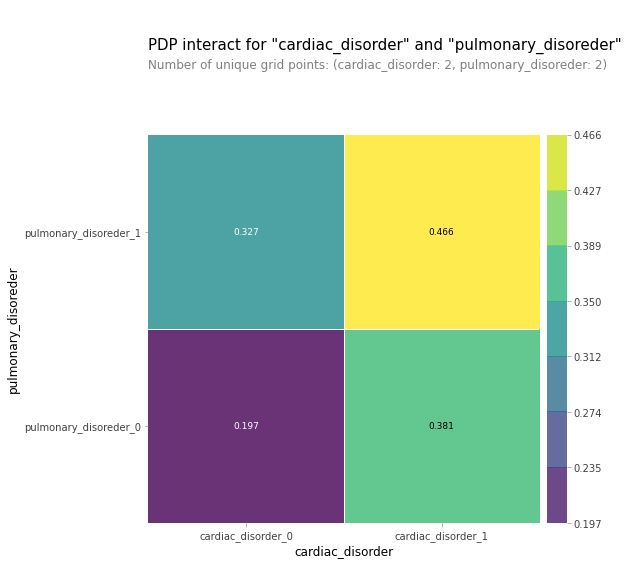

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['cardiac_disorder', 'pulmonary_disoreder']

interaction = pdp_interact(
    model=pipe_best_c, 
    dataset=X_test_enc_c,
    model_features=X_test_enc_c.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

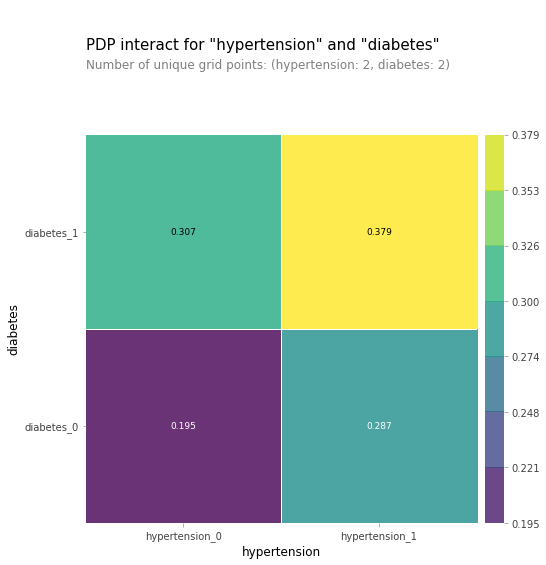

In [ ]:
features = ['hypertension', 'diabetes']

interaction = pdp_interact(
    model=pipe_best_c, 
    dataset=X_test_enc_c,
    model_features=X_test_enc_c.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

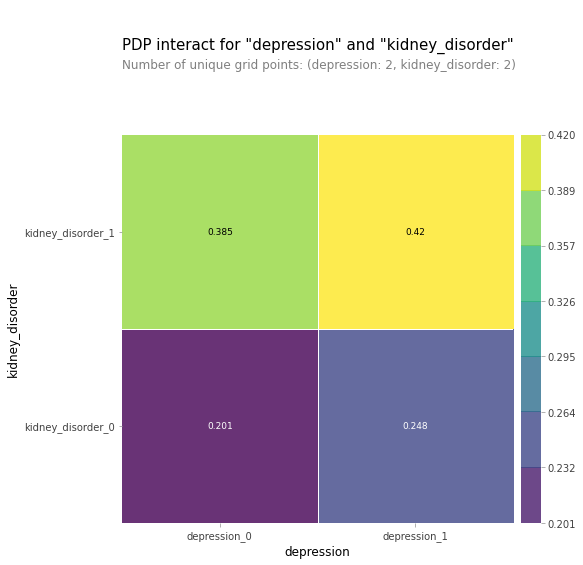

In [ ]:
features = ['depression', 'kidney_disorder']

interaction = pdp_interact(
    model=pipe_best_c, 
    dataset=X_test_enc_c,
    model_features=X_test_enc_c.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

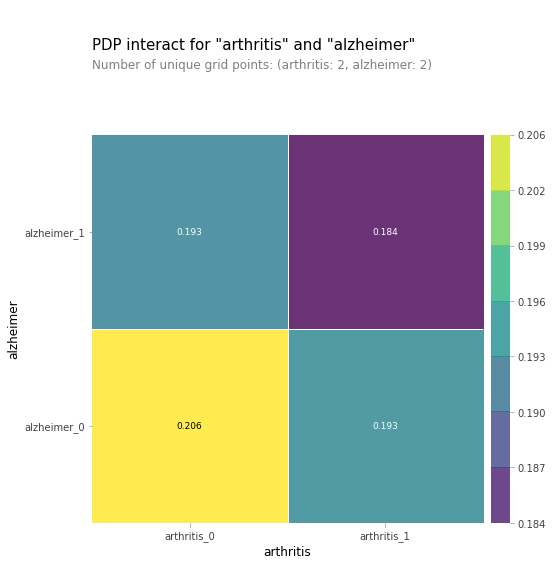

In [ ]:
features = ['arthritis', 'alzheimer']

interaction = pdp_interact(
    model=pipe_best_c, 
    dataset=X_test_enc_c,
    model_features=X_test_enc_c.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

permutation importance 에서 음수의 결과를 보인 alzheimer, arthritis(관절질환), 호흡기 질환 등을 제외하고는 다수의 질환이 동시에 있을 경우 백신 부작용을 일으킬 가능성이 높아진다는 것을 확인할 수 있다.

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 12.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=5e7a47ff099b9c0dd1566bca331ec3bd1b6edfa0b41f8a0d407d8c0f0d9af7be
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

row = X_test_enc_c.iloc[[5]]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], features=row)

실제 target값이 0 인 샘플에 대해서, 예측값은 0.00으로, 

Positive 영향을 가장 많이 주는 요인 :
1. AGE : 55세
2. STATE : 1
3. V_ADMINBY : 1 (unknown)

In [ ]:
row = X_test_enc_c.loc[[1571]]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], features=row)

실제 target값이 1 인 샘플에 대해서, 예측값은 0.68로,

Positive 영향을 가장 많이 주는 요인 :
1. AGE : 66
2. V_ADMINBY : 7 (SEN)
